In [1]:
# Import the packages we will use
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math

In [2]:
# The following directive activates inline plotting
%matplotlib inline

### Bins visualization

In [3]:
# 1 or 6 to assign chr
chr_num = 1
chr = 'chr' + str(chr_num)

In [17]:
arr = np.load('arrs/2kb_chr'+str(chr_num)+'_log.npy')

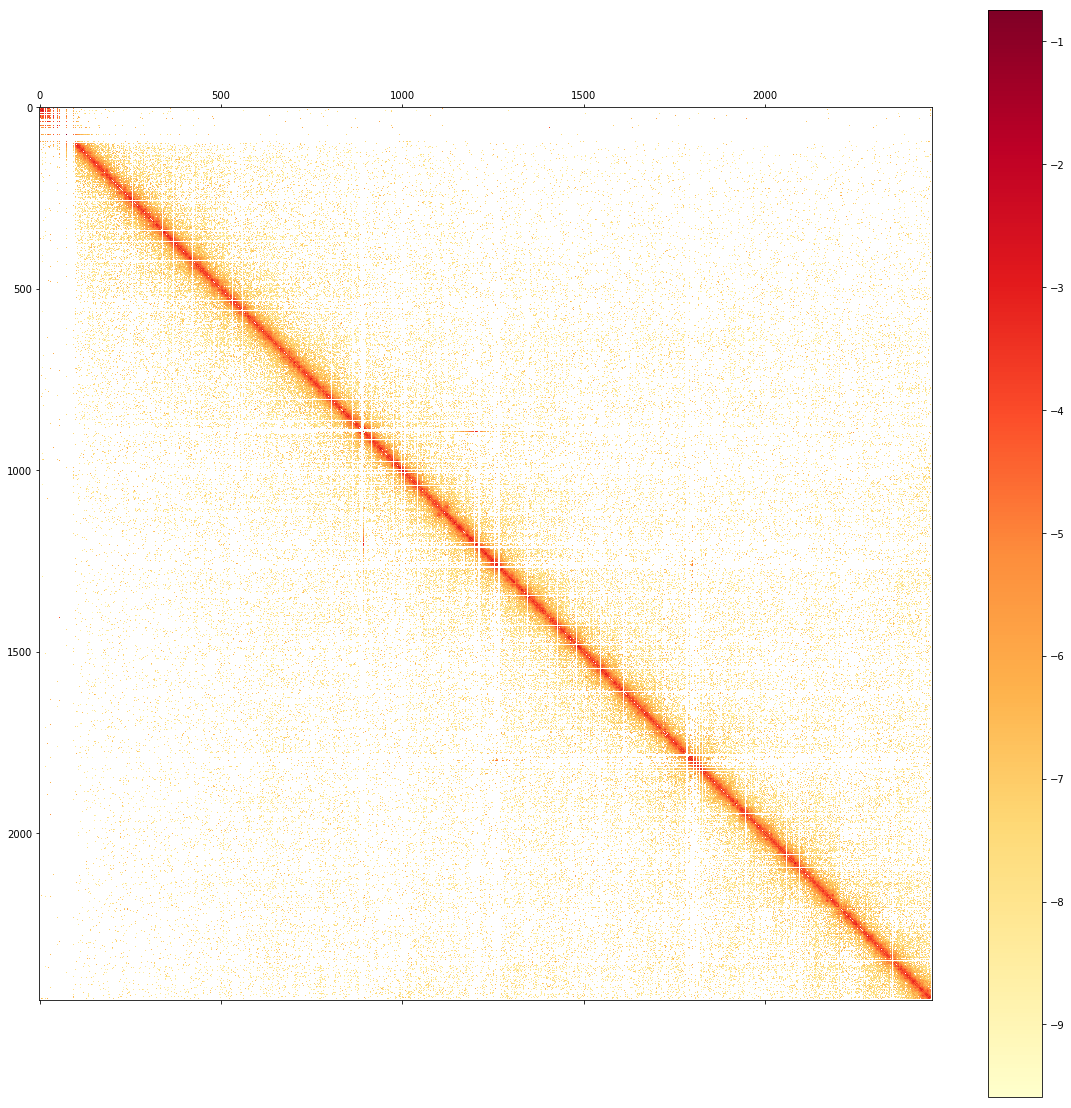

In [18]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
im = ax.matshow(arr, cmap='YlOrRd')
fig.colorbar(im)

It divides each diagonal of a Hi-C contact map by its' mean.  
It also does it in a smart way: it calculates averages over stripes from X to X*1.05, and divides each stripe by its mean.  
It allows to avoid divergence far from the main diagonal with a very few reads.  
(comment from __mirnylib__)

In [4]:
arr = np.load('arrs/2kb_chr'+str(chr_num)+'_norm_log.npy')

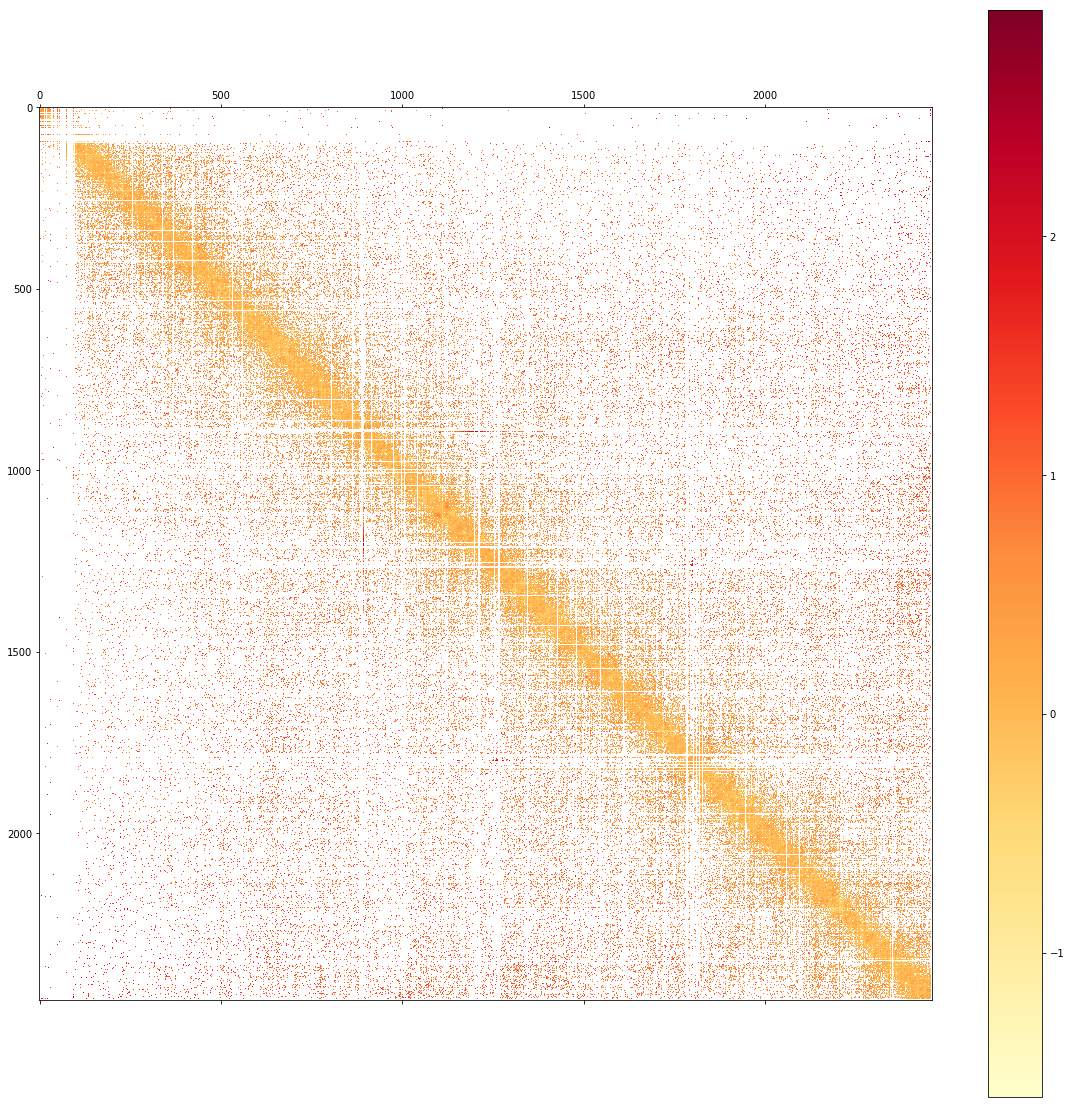

In [5]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
im = ax.matshow(arr, cmap='YlOrRd')
fig.colorbar(im)

### Read loops info

In [6]:
loops_info = pandas.read_excel('dicty_loop_positions_Chr1_Chr6.xlsx')
loops_positions = loops_info[loops_info.Chr == chr_num]

### Visualize loops on plots

In [7]:
loops_x = loops_positions['Genomic bin, Left base'].values
loops_y = loops_positions['Genomic bin, Right base'].values
loops_type = loops_positions['"Extrusion track"'].values
loops_size = loops_positions['Size (Kb)'].values

In [8]:
edgecolors = []
for l in loops_type:
    if l == 0:
        edgecolors.append('blue')
    elif l == 1:
        edgecolors.append('lime')
    else:
        edgecolors.append('cyan')

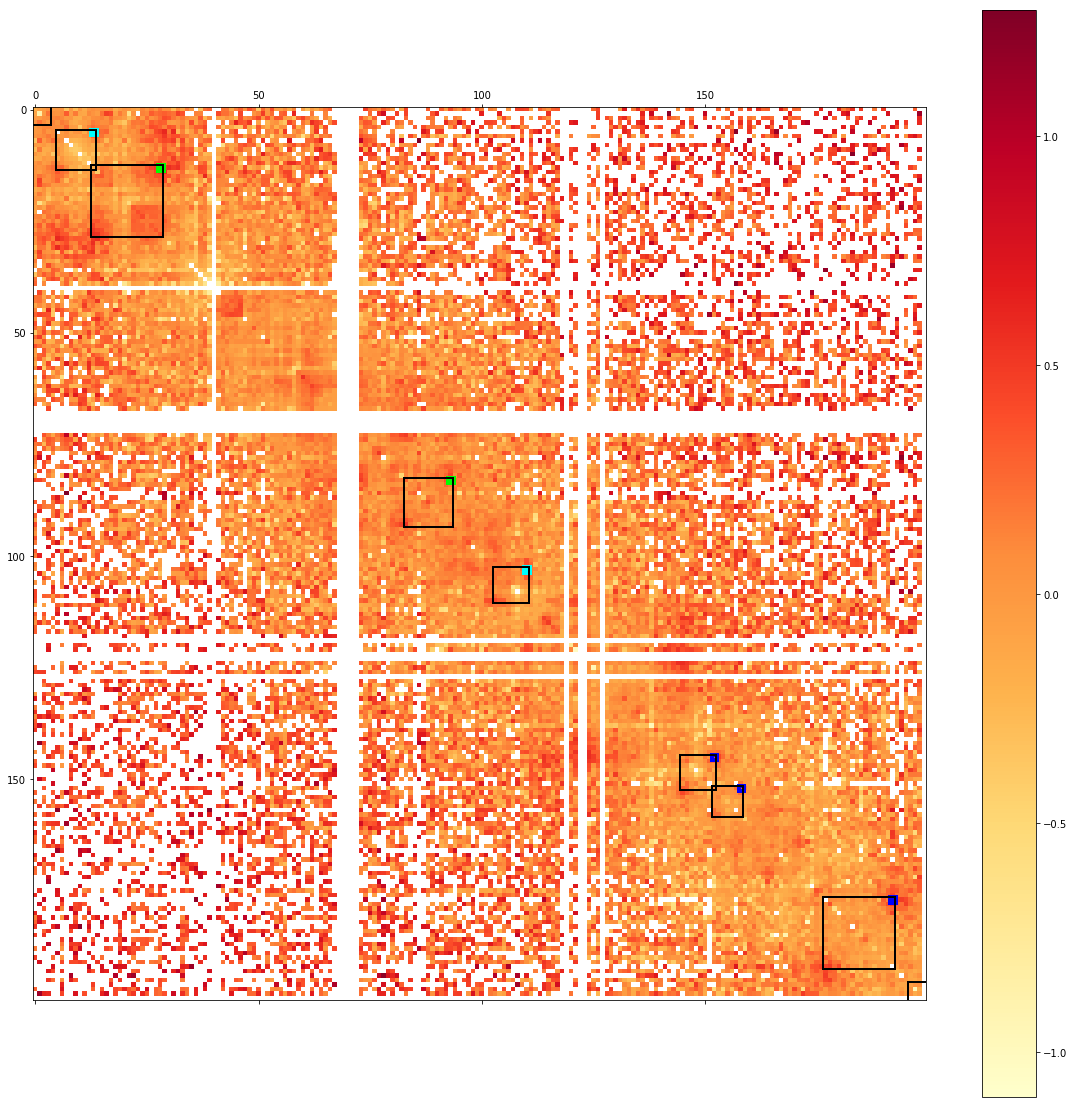

In [9]:
start_bin = 300
end_bin = start_bin + 200

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
im = ax.matshow(arr[start_bin:end_bin, start_bin:end_bin], cmap='YlOrRd')
fig.colorbar(im)

for idx, x in enumerate(loops_x):
    loop = matplotlib.patches.Rectangle((loops_y[idx]-1.5-start_bin, x-1.5-start_bin), 1, 1,
                                        fill=None, alpha=1, edgecolor=edgecolors[idx], linewidth=5.0)
    ax.add_patch(loop)
    #loop = matplotlib.patches.Rectangle((x-1.5-start_bin, loops_y[idx]-1.5-start_bin), 1, 1,
    #                                    fill=None, alpha=1, edgecolor=edgecolors[idx], linewidth=5.0)
    #ax.add_patch(loop)
    loop_tr = matplotlib.patches.Rectangle((loops_y[idx]-0.5-loops_size[idx]/2-start_bin, x-1.5-start_bin),
                                           loops_size[idx]/2, loops_size[idx]/2, fill=None, alpha=1, edgecolor='black',
                                          linewidth=2.0)
    ax.add_patch(loop_tr)

### Average loop

###### Single loop

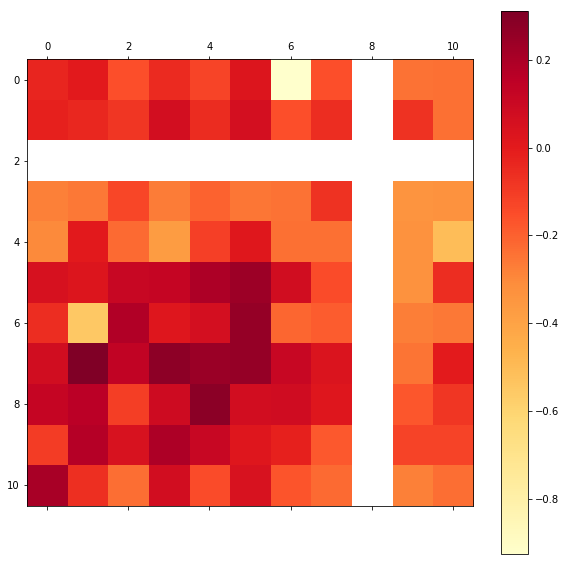

In [10]:
window_size = 11

loop_y_centroid = loops_y[20]-1
loop_x_centroid = loops_x[20]-1

loop_window = arr[loop_y_centroid-math.floor(window_size/2):loop_y_centroid+math.ceil(window_size/2),
                  loop_x_centroid-math.floor(window_size/2):loop_x_centroid+math.ceil(window_size/2)]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

im = ax.matshow(loop_window, cmap='YlOrRd')

fig.colorbar(im)

In [11]:
def sum_loops(arr, resolution, window_size = 10):
    loop_sum = np.zeros((window_size, window_size))

    for idx, x in enumerate(loops_x):

        loop_y_centroid = loops_y[idx]-1
        loop_x_centroid = x-1
        
        if loop_y_centroid-math.floor(window_size/2) > 0 and loop_x_centroid-math.floor(window_size/2) > 0:
            
            loop_window = arr[loop_y_centroid-math.floor(window_size/2):loop_y_centroid+math.ceil(window_size/2),
                              loop_x_centroid-math.floor(window_size/2):loop_x_centroid+math.ceil(window_size/2)]

            loop_window[loop_window == -np.inf] = -1
            loop_sum = loop_sum + np.nan_to_num(loop_window) 
        
    return loop_sum

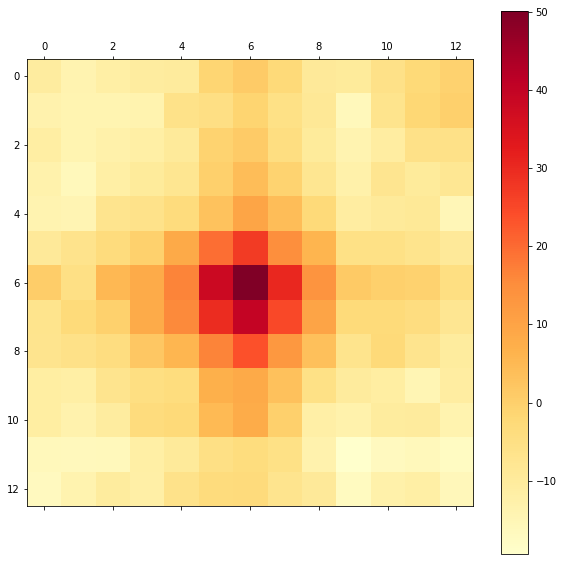

In [12]:
resolution = 10**4

window_size = 13
loop_sum = sum_loops(arr, resolution, window_size)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

im = ax.matshow(loop_sum, cmap='YlOrRd')

fig.colorbar(im)

### Scaling

In [13]:
def resize_image_arr(original_image, width, height):
    resize_image = np.zeros(shape=(width,height))
    for W in range(width):
        for H in range(height):
            new_width = int( W * original_image.shape[0] / width )
            new_height = int( H * original_image.shape[1] / height )
            resize_image[W][H] = original_image[new_width][new_height]
            
    return resize_image

In [14]:
loop_new_size = 100

In [15]:
width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for idx, x in enumerate(loops_x): 
    window = 10
    original_image = arr[loops_x[idx]-window:loops_y[idx]+window, loops_x[idx]-window:loops_y[idx]+window]
    resize_image = resize_image_arr(original_image, width, height)

    resize_image[resize_image == -np.inf] = 0
    resize_image = np.nan_to_num(resize_image) 
    
    resize_image_sum = resize_image_sum + resize_image

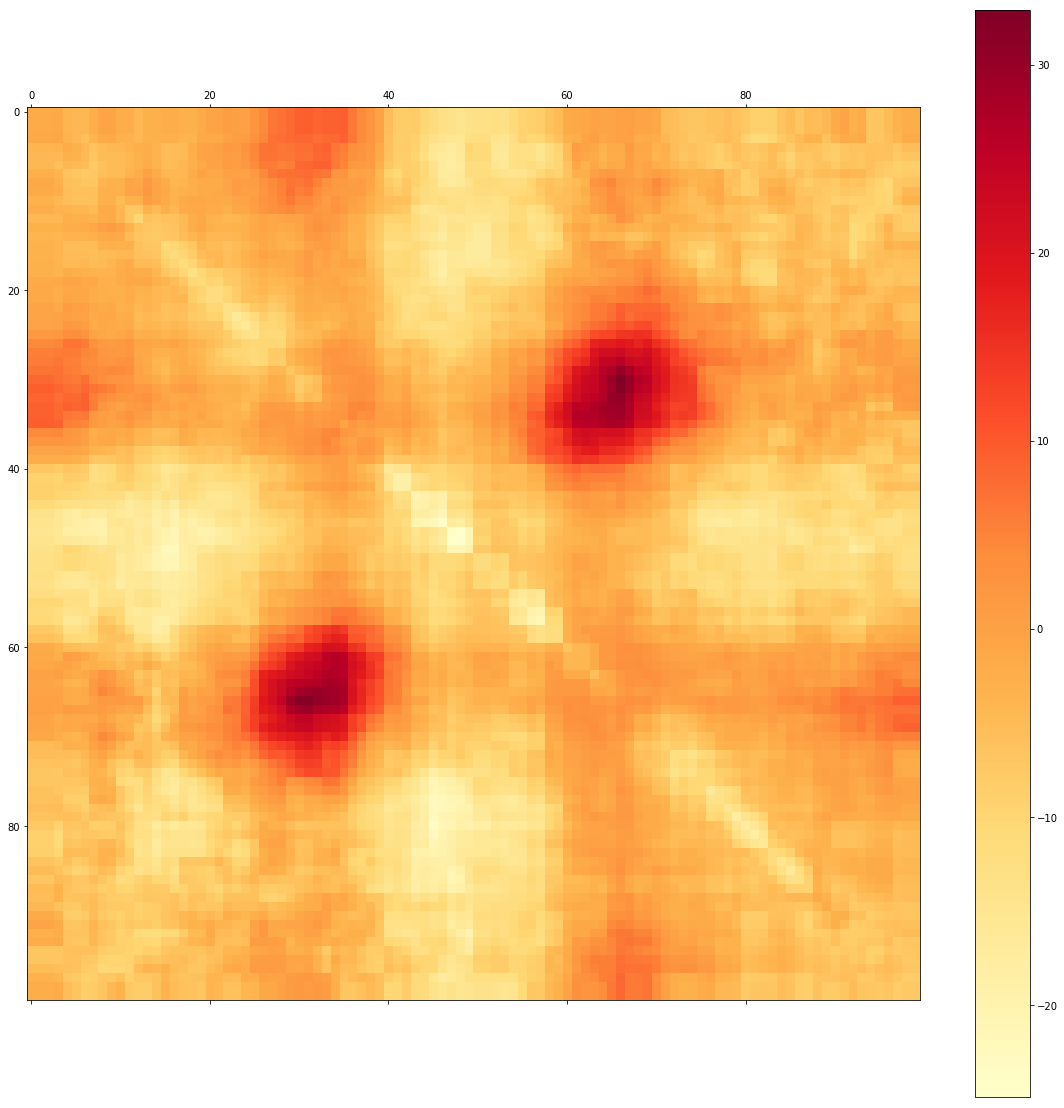

In [16]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
im = ax.matshow(resize_image_sum, cmap='YlOrRd')
fig.colorbar(im)